In [0]:
!pip install scipy==1.1.0 --user


     |████████████████████████████████| 31.2MB 124kB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import scipy
from scipy.misc import imresize, imread


In [0]:
!pip install numpy==1.16.2


     |████████████████████████████████| 17.3MB 231kB/s 
ERROR: tensorflow-model-optimization 0.2.1 requires enum34~=1.1, which is not installed.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2


In [0]:
import numpy as np
print(np.__version__)

1.16.2


In [0]:
import matplotlib.pylab as plt
import itertools
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/gdrive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
X = np.load('/content/gdrive/My Drive/lymphoma-subtype-classification-fl-vs-cll/X.npy') 
y = np.load('/content/gdrive/My Drive/lymphoma-subtype-classification-fl-vs-cll/Y.npy') 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [0]:
X_train = X_train / 256.0
X_test = X_test / 256.0

In [0]:
X_train_shape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_test_shape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]

X_train_flat = X_train.reshape(X_train.shape[0], X_train_shape)
X_test_flat = X_test.reshape(X_test.shape[0], X_test_shape)

In [0]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [0]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def PlotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')


In [0]:
def PlotConfusionMatrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

![Texte alternatif…](https://eg.bucknell.edu/~cld028/courses/379-FA19/images/ConvEx.gif)
For the first action: convolutional2D, we are taking the multiplication of a filter of dimension 3*3. 
This filter will be applied on the whole picture and will calculate the output of a multiplication of each values from the picture (each value of each pixel) with the value from our filter (ones on a X :


|1 0 1 |    
|0 1 0 |               (the filter)

|1 0 1 |  
x


|1 1 1|

|0 1 1|                 (the values from the picture)

|0 0 1|

![texte du lien](https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 4437 samples, validate on 1110 samples
Epoch 1/12
4437/4437 [==============================] - 40s 9ms/sample - loss: 0.7283 - acc: 0.4875 - val_loss: 0.6912 - val_acc: 0.5387
Epoch 2/12
4437/4437 [==============================] - 39s 9ms/sample - loss: 0.7143 - acc: 0.4992 - val_loss: 0.6903 - val_acc: 0.4982
Epoch 3/12
4437/4437 [==============================] - 39s 9ms/sample - loss: 0.7099 - acc: 0.4985 - val_loss: 0.6900 - val_acc: 0.4973
Epoch 4/12
4437/4437 [==============================] - 40s 9ms/sample - loss: 0.7053 - acc: 0.5098 - val_loss: 0.6891 - val_acc: 0.4982
Epoch 5/12
4437/4437 [==============================] - 39s 9ms/sample - loss: 0.7025 - acc: 0.5001 - val_loss: 0.6877 - val_acc: 0.4982
Epoch 6/12
4437/4437 [==============================] - 39s 9ms/sample - loss: 0.7019 - acc: 0.5053 - val_loss: 0.6865 - val_acc: 0.5117
Epoch 7/12
4437/4437 [===========================

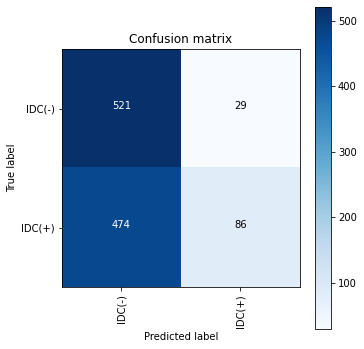

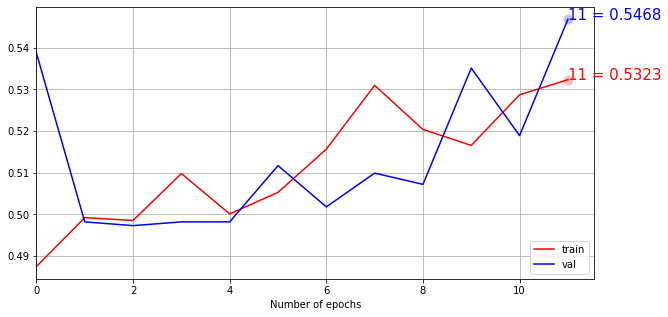

In [0]:
def runKerasCNN(a,b,c,d):
    batch_size = 128
    num_classes = 2
    epochs = 12  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN #1A - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    PlotConfusionMatrix(confusion_mtx, classes = list(map_characters.values())) 
runKerasCNN(X_train, y_train,  X_test, y_test)
PlotKerasLearningCurve()

Train on 4437 samples, validate on 1110 samples
Epoch 1/12
4437/4437 [==============================] - 73s 17ms/sample - loss: 2.0379 - acc: 0.6811 - val_loss: 0.6591 - val_acc: 0.7279
Epoch 2/12
4437/4437 [==============================] - 73s 16ms/sample - loss: 0.5763 - acc: 0.7395 - val_loss: 0.6746 - val_acc: 0.5396
Epoch 3/12
4437/4437 [==============================] - 72s 16ms/sample - loss: 0.5775 - acc: 0.7417 - val_loss: 0.6250 - val_acc: 0.6973
Epoch 4/12
4437/4437 [==============================] - 72s 16ms/sample - loss: 0.5460 - acc: 0.7507 - val_loss: 0.5930 - val_acc: 0.7045
Epoch 5/12
4437/4437 [==============================] - 72s 16ms/sample - loss: 0.5286 - acc: 0.7688 - val_loss: 0.5568 - val_acc: 0.7441
Epoch 6/12
4437/4437 [==============================] - 72s 16ms/sample - loss: 0.5381 - acc: 0.7751 - val_loss: 0.5897 - val_acc: 0.7189
Epoch 7/12
4437/4437 [==============================] - 72s 16ms/sample - loss: 0.5077 - acc: 0.7794 - val_loss: 1.1275 - va

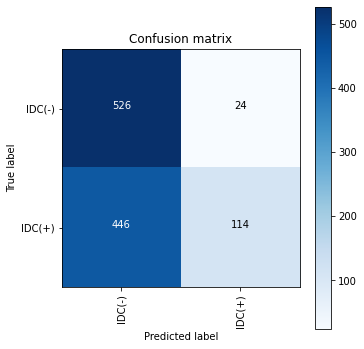

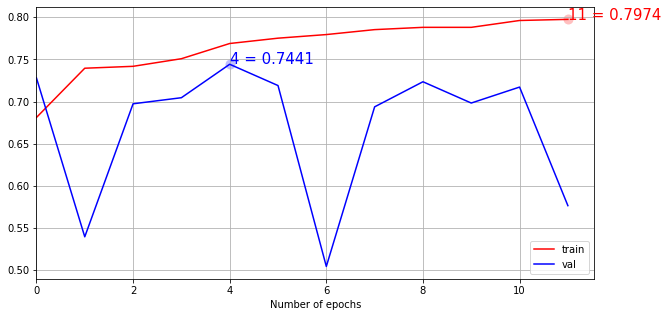

In [0]:
def KerasModelOne(X_train, y_train, X_test, y_test):
    # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out   
    batch_size = 128
    num_classes = 2
    epochs = 12
    # input image dimensions
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = input_shape))
    model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 86, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = "softmax"))
    optimizer = RMSprop(lr=0.001, decay=1e-6)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    model.fit(X_train, y_train,
                  batch_size=batch_size,
                  verbose=1,
                  epochs=epochs,
                  validation_data=(X_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(X_test,y_test, verbose=0)
    print('\nKeras CNN #1 - accuracy:', score[1], '\n')
    y_pred = model.predict(X_test)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='') 
    y_pred_classes = np.argmax(y_pred,axis = 1) 
    y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
    PlotConfusionMatrix(confusion_mtx, classes = list(map_characters.values())) 
KerasModelOne(X_train, y_train, X_test, y_test)
PlotKerasLearningCurve()

Let's implement image augmentation

![Texte alternatif…](https://miro.medium.com/max/605/0*Utma-dS47hSoQ6Zt)

Epoch 1/12
139/138 [==============================] - 46s 333ms/step - loss: 0.7079 - acc: 0.4877 - val_loss: 0.6911 - val_acc: 0.4928
Epoch 2/12
139/138 [==============================] - 45s 326ms/step - loss: 0.6967 - acc: 0.5274 - val_loss: 0.6848 - val_acc: 0.5225
Epoch 3/12
139/138 [==============================] - 45s 325ms/step - loss: 0.6869 - acc: 0.5384 - val_loss: 0.6788 - val_acc: 0.5694
Epoch 4/12
139/138 [==============================] - 45s 327ms/step - loss: 0.6807 - acc: 0.5569 - val_loss: 0.6732 - val_acc: 0.5883
Epoch 5/12
139/138 [==============================] - 45s 325ms/step - loss: 0.6760 - acc: 0.5806 - val_loss: 0.6666 - val_acc: 0.6360
Epoch 6/12
139/138 [==============================] - 45s 325ms/step - loss: 0.6737 - acc: 0.5835 - val_loss: 0.6612 - val_acc: 0.6721
Epoch 7/12
139/138 [==============================] - 45s 327ms/step - loss: 0.6662 - acc: 0.6108 - val_loss: 0.6556 - val_acc: 0.6622
Epoch 8/12
139/138 [==============================] - 4

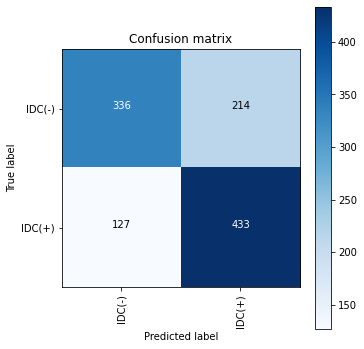

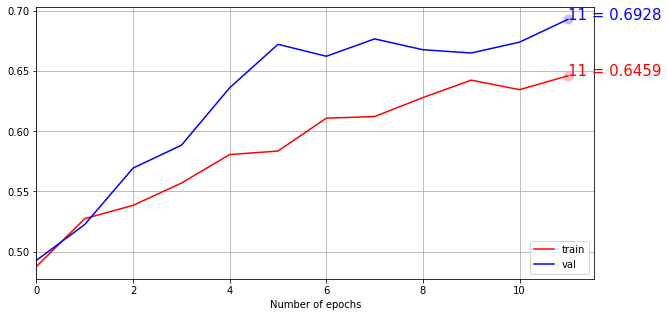

In [0]:
def KerasCNNAugment(X_train, y_train,  X_test, y_test):
    batch_size = 128
    num_classes = 2
    epochs = 12
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
    model.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                        steps_per_epoch=len(X_train) / 32, epochs=epochs, 
                        validation_data = (X_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(X_test, y_test, verbose=0)
    print('\nKeras CNN #3 - accuracy:', score[1],'\n')
    y_pred = model.predict(X_test)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    score = model.evaluate(X_test, y_test, verbose=0)
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(y_test,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    PlotConfusionMatrix(confusion_mtx, classes = list(map_characters.values())) 
KerasCNNAugment(X_train, y_train,  X_test, y_test)
PlotKerasLearningCurve()